## Labwork 4 | Point localization.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def to_cartesian(p):
    return p[:2] / p[2]

def plot(*shapes,
         size=6,
         lim=15,
         major=5,
         with_points=True,
         point_size=5,
         close=True,
         from_origin=False,
         show_legend=False,
         **common_plot_kw):
    fig, ax = plt.subplots(figsize=(size, size))

    for item in shapes:
        if isinstance(item, tuple):
            shape, plot_kw = item
        else:
            shape, plot_kw = item, {}

        shape = np.asarray(shape)
        x = shape[:, 0] / shape[:, 2]
        y = shape[:, 1] / shape[:, 2]

        if close:
            xx = np.append(x, x[0])
            yy = np.append(y, y[0])
        else:
            xx, yy = x, y

        if "label" in plot_kw:
            show_legend = True

        ax.plot(xx, yy, **({"linewidth": 1.6} | common_plot_kw | plot_kw))

        if with_points:
            ax.scatter(x, y, s=point_size, zorder=3)

    ax.set_aspect("equal")

    if from_origin:
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)
        major_ticks = np.arange(0, lim + 1, major)
        minor_ticks = np.arange(0, lim + 1, 1)
    else:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        major_ticks = np.arange(-lim, lim + 1, major)
        minor_ticks = np.arange(-lim, lim + 1, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="major", linestyle="-", linewidth=0.8)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)

    if show_legend:
        ax.legend()

    plt.show()




### Task 1

Задайте отрезки $s_1, s_2, s_3, ..., s_{10}$ (должно быть не менее двух пар пересекающихся отрезков среди заданных).

Найдите пересекающиеся отрезки:

- параметризацией прямых, содержащих отрезки (найдите точки пересечения);
- методом косых произведений;
- методом заметающей прямой (алгоритмом Бентли-Оттмана).


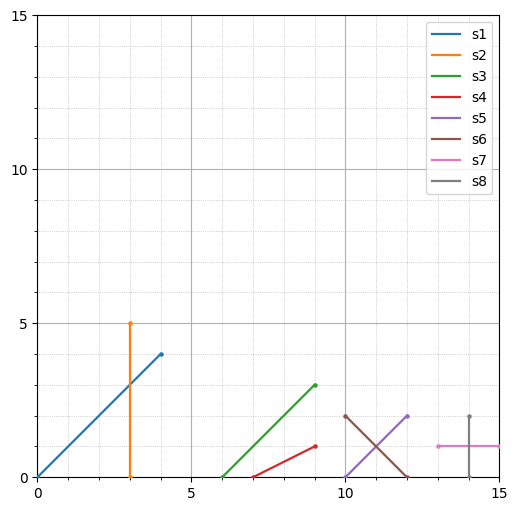

In [3]:
segments = [
  [np.array([0, 0, 1]), np.array([4, 4, 1])],
  [np.array([3, 0, 1]), np.array([3, 5, 1])],
  [np.array([6, 0, 1]), np.array([9, 3, 1])],
  [np.array([7, 0, 1]), np.array([9, 1, 1])],
  [np.array([10, 0, 1]), np.array([12, 2, 1])],
  [np.array([10, 2, 1]), np.array([12, 0, 1])],
  [np.array([13, 1, 1]), np.array([15, 1, 1])],
  [np.array([14, 0, 1]), np.array([14, 2, 1])]
]

plot(*[(np.array(seg), {"label": f"s{i+1}"}) for i, seg in enumerate(segments)],
     from_origin=True, close=False, show_legend=True)

#### параметризацией прямых, содержащих отрезки (найдите точки пересечения);

1. **Задание отрезков:**

$$
A = (x_1, y_1, 1), \quad B = (x_2, y_2, 1)
$$

$$
\text{line} = A \times B
$$

Пересечение:

$$
P = \text{line}_1 \times \text{line}_2
$$

Если $P_2 = 0$, то прямые параллельны — пересечения нет.

$$
P = \left( \frac{P_0}{P_2}, \frac{P_1}{P_2} \right)
$$


[[ 3.  3.  1.]
 [11.  1.  1.]
 [14.  1.  1.]]


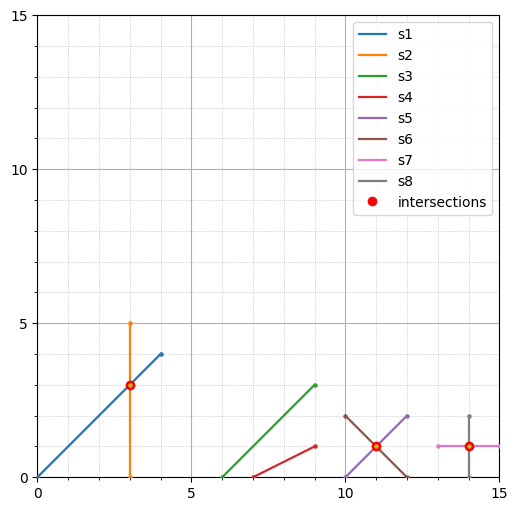

In [33]:

from itertools import combinations


def param_intersect(seg1, seg2):
    A, B = seg1
    C, D = seg2

    # 1. Compute lines from pairs of points
    line1 = np.cross(A, B)
    line2 = np.cross(C, D)

    # 2. Compute intersection point (in homogeneous coords)
    P = np.cross(line1, line2)
    
    if abs(P[2]) < 1e-10:
        return None

    # 4. Normalize to Cartesian for segment bounds check
    P_cart = to_cartesian(P)

    # 5. Check if point lies on both segments (bounding box method)
    def point_on_segment(P, A, B):
        A_cart, B_cart = to_cartesian(A), to_cartesian(B)
        min_x, max_x = sorted([A_cart[0], B_cart[0]])
        min_y, max_y = sorted([A_cart[1], B_cart[1]])
        return (min_x - 1e-10 <= P[0] <= max_x + 1e-10 and
                min_y - 1e-10 <= P[1] <= max_y + 1e-10)

    if point_on_segment(P_cart, A, B) and point_on_segment(P_cart, C, D):
        return P_cart

    return None

param_results = []

for i, j in combinations(range(len(segments)), 2):
    p = param_intersect(segments[i], segments[j])
    if p is not None:
        param_results.append(((i + 1, j + 1), p))

segment_lines = [(np.vstack([a, b]), {"label": f"s{i+1}"}) for i, (a, b) in enumerate(segments)]
points = np.array([np.append(p, 1) for _, p in param_results])

print(points)

plot(*segment_lines,
     (points, {"color": "red", "label": "intersections", "marker": "o", "linestyle": "None"}),
     from_origin=True, close=False, show_legend=True)

#### методом косых произведений

Два отрезка $AB$ и $CD$ пересекаются **тогда и только тогда**, когда выполняются следующие условия:

1. Точки $C$ и $D$ лежат по разные стороны от прямой $AB$;
2. Точки $A$ и $B$ лежат по разные стороны от прямой $CD$.

Это проверяется через **знаки векторных косых произведений**.

Для отрезка $AB$ и точек $C, D$:

Обозначим:

- $\vec{AB} = B - A$
- $\vec{AC} = C - A$
- $\vec{AD} = D - A$

Тогда:

- $\text{cross}(\vec{AB}, \vec{AC}) \cdot \text{cross}(\vec{AB}, \vec{AD}) < 0$

Аналогично выполняется проверка для прямой $CD$ и точек $A, B$:

- $\text{cross}(\vec{CD}, \vec{CA}) \cdot \text{cross}(\vec{CD}, \vec{CB}) < 0$

Условие пересечения отрезков:

$$
\text{cross}(\vec{AB}, \vec{AC}) \cdot \text{cross}(\vec{AB}, \vec{AD}) < 0 \quad \text{и} \quad
\text{cross}(\vec{CD}, \vec{CA}) \cdot \text{cross}(\vec{CD}, \vec{CB}) < 0
$$


[(1, 2), (5, 6), (7, 8)]


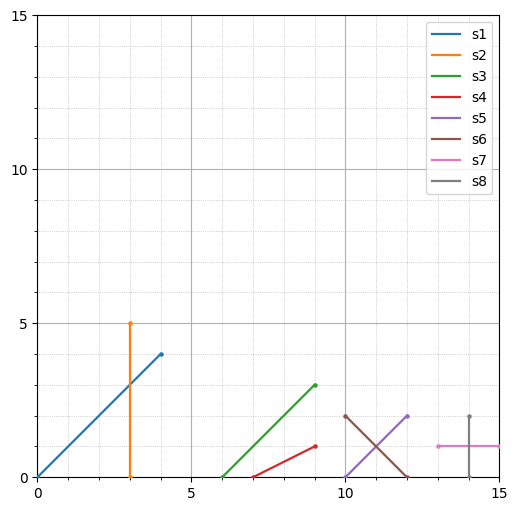

In [21]:
def cross_2d(u, v):
    return u[0] * v[1] - u[1] * v[0]

def to_vec(p1, p2):
    return to_cartesian(p2) - to_cartesian(p1)

def cross_intersect(seg1, seg2):
    A, B = seg1
    C, D = seg2

    AB = to_vec(A, B)
    AC = to_vec(A, C)
    AD = to_vec(A, D)

    CD = to_vec(C, D)
    CA = to_vec(C, A)
    CB = to_vec(C, B)

    cross1 = cross_2d(AB, AC) * cross_2d(AB, AD)
    cross2 = cross_2d(CD, CA) * cross_2d(CD, CB)

    return cross1 < 0 and cross2 < 0
  
cross_results = []

for i, j in combinations(range(len(segments)), 2):
    if cross_intersect(segments[i], segments[j]):
        cross_results.append((i + 1, j + 1))

print(cross_results)

plot(*segment_lines,
     from_origin=True, close=False, show_legend=True)

#### методом заметающей прямой (алгоритмом Бентли-Оттмана).

https://www.youtube.com/watch?v=be5y0BVQ5kg

Работает за $O((n + k)log(n))$ где $k$ - количество пересечений.


Found 3 intersection(s):
At [3. 3. 1.], between segments (array([3, 0]), array([3, 5])) and (array([0, 0]), array([4, 4]))
At [11.  1.  1.], between segments (array([10,  0]), array([12,  2])) and (array([10,  2]), array([12,  0]))
At [14.  1.  1.], between segments (array([14,  0]), array([14,  2])) and (array([13,  1]), array([15,  1]))


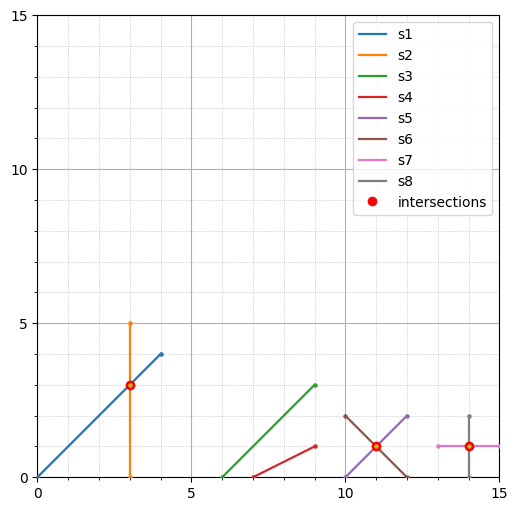

In [ ]:
import numpy as np
import heapq
import bisect

class Event:
    def __init__(self, x, point, segments, kind):
        self.x = x
        self.point = point  # tuple (x, y)
        self.segments = segments  # one or two segments
        self.kind = kind  # 'start', 'end', 'intersection'

    def __lt__(self, other):
        return (self.x, self.point[1]) < (other.x, other.point[1])

def segment_y_at(seg, x):
    p, q = seg
    if np.isclose(p[0], q[0]):
        return min(p[1], q[1])
    return p[1] + (x - p[0]) * (q[1] - p[1]) / (q[0] - p[0])

def line_intersection(p1, p2, q1, q2):
    A = np.array([
        [p2[0] - p1[0], q1[0] - q2[0]],
        [p2[1] - p1[1], q1[1] - q2[1]]
    ])
    b = np.array([q1[0] - p1[0], q1[1] - p1[1]])
    if np.isclose(np.linalg.det(A), 0):
        return None
    t, u = np.linalg.solve(A, b)
    if 0 <= t <= 1 and 0 <= u <= 1:
        return p1 + t * (p2 - p1)
    return None

def bentley_ottmann(h_segments):
    segments = [(a[:2], b[:2]) for a, b in h_segments]
    events = []
    for seg in segments:
        p, q = seg
        if p[0] > q[0]:
            p, q = q, p
        heapq.heappush(events, Event(p[0], tuple(p), [seg], 'start'))
        heapq.heappush(events, Event(q[0], tuple(q), [seg], 'end'))

    status = []
    intersections = []
    seen = set()

    def segments_equal(s1, s2):
        return np.allclose(s1[0], s2[0]) and np.allclose(s1[1], s2[1]) or \
           np.allclose(s1[0], s2[1]) and np.allclose(s1[1], s2[0])

    def seg_key(s, x):
        return segment_y_at(s, x)

    def find_index(s, x):
        return bisect.bisect_left([seg_key(seg, x) for seg in status], seg_key(s, x))

    def add_segment(s, x):
        i = find_index(s, x)
        status.insert(i, s)
        return i

    def remove_segment(s, x):
        for i, seg in enumerate(status):
            if segments_equal(seg, s):
                status.pop(i)
                break

    def neighbors(i):
        l = status[i - 1] if i > 0 else None
        r = status[i + 1] if i < len(status) - 1 else None
        return l, r

    def check(s1, s2, x):
        if s1 is None or s2 is None or segments_equal(s1, s2):
            return
        pt = line_intersection(np.array(s1[0]), np.array(s1[1]),
                               np.array(s2[0]), np.array(s2[1]))
        if pt is not None and pt[0] >= x - 1e-8:
            key = (round(pt[0], 8), round(pt[1], 8))
            if key not in seen:
                seen.add(key)
                heapq.heappush(events, Event(pt[0], tuple(pt), [s1, s2], 'intersection'))

    while events:
        event = heapq.heappop(events)
        x = event.x
        if event.kind == 'start':
            seg = event.segments[0]
            i = add_segment(seg, x)
            l, r = neighbors(i)
            check(l, seg, x)
            check(seg, r, x)
        elif event.kind == 'end':
            seg = event.segments[0]
            i = find_index(seg, x)
            remove_segment(seg, x)
            if 0 < i <= len(status):
                l = status[i - 1] if i - 1 >= 0 else None
                r = status[i] if i < len(status) else None
                check(l, r, x)
        elif event.kind == 'intersection':
            s1, s2 = event.segments
            pt = np.array([event.point[0], event.point[1], 1])  # back to homogeneous
            intersections.append((s1, s2, pt))
            # swap s1 and s2
            i1 = find_index(s1, x)
            i2 = find_index(s2, x)
            if i1 > i2:
                i1, i2 = i2, i1
                s1, s2 = s2, s1
            if i2 < len(status) and segments_equal(status[i1], s1) and segments_equal(status[i2], s2):
                status[i1], status[i2] = status[i2], status[i1]
                l, _ = neighbors(i1)
                _, r = neighbors(i2)
                check(l, status[i1], x)
                check(status[i2], r, x)
    print(f"Found {len(intersections)} intersection(s):")
    for s1, s2, pt in intersections:
        print(f"At {pt}, between segments {s1} and {s2}")

    return intersections

results = bentley_ottmann(segments)

segment_lines = [(np.vstack([a, b]), {"label": f"s{i+1}"}) for i, (a, b) in enumerate(segments)]
inter_points = np.array([pt for _, _, pt in results])

plot(*segment_lines,
     (inter_points, {"color": "red", "label": "intersections", "marker": "o", "linestyle": "None"}),
     from_origin=True, close=False, show_legend=True)

### Task 2

Задайте простой 𝑛-угольник координатами его вершин $P_1, P_2, ..., P_n (n \geq 7)$ и точки $M_1, M_2, ..., M_k  (k \geq 5)$.

Определите положение точек $M_1, M_2, ..., M_k$ относительно n-угольника:

- угловым методом;
- лучевым методом.


In [6]:
# Вершины 9-угольника (например, правильный)
n = 9
theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
polygon = [(10 + 8 * np.cos(t), 10 + 8 * np.sin(t)) for t in theta]

# 5 случайных точек
test_points = [(12, 10), (5, 5), (18, 10), (10, 10), (14, 14)]


In [7]:
import numpy as np

def angle_sum_method(polygon, point):
    total_angle = 0
    px, py = point
    n = len(polygon)

    for i in range(n):
        x1, y1 = polygon[i][0] - px, polygon[i][1] - py
        x2, y2 = polygon[(i + 1) % n][0] - px, polygon[(i + 1) % n][1] - py

        # Векторное и скалярное произведения
        dot = x1 * x2 + y1 * y2
        cross = x1 * y2 - x2 * y1

        angle = np.arctan2(cross, dot)
        total_angle += angle

    return abs(round(total_angle / (2 * np.pi))) == 1  # True if inside


In [8]:
def ray_casting_method(polygon, point):
    x, y = point
    n = len(polygon)
    inside = False

    for i in range(n):
        x0, y0 = polygon[i]
        x1, y1 = polygon[(i + 1) % n]

        if ((y0 > y) != (y1 > y)):
            x_intersect = (x1 - x0) * (y - y0) / (y1 - y0 + 1e-12) + x0
            if x < x_intersect:
                inside = not inside

    return inside
